In [16]:
import sys
import os 
print(os.getcwd())
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
sys.path.append('..')

import torch


/workspace/project/project/misc


In [17]:
print(os.getcwd())
from models.pytorchvideo_models import WalkVideoClassificationLightningModule
from dataloader.data_loader import WalkDataModule

from pytorch_lightning import Trainer

from IPython.display import clear_output

clear_output()

import torchmetrics
import torchmetrics

In [18]:
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [19]:
from parameters import get_parameters

VIDEO_LENGTH = ['1', '2', '3']
VIDEO_FRAME = ['8', '16', '32']

opt, _ = get_parameters()
opt.num_workers = 4
opt.batch_size = 8
opt.gpu_num = 1

opt.version = '1201_1_16'
opt.model = "resnet"
opt.model_depth = 50
opt.model_class_num = 1

# opt.clip_duration = 2
# opt.uniform_temporal_subsample_num = 30
opt.version = opt.version + '_' + opt.model + '_depth' + str(opt.model_depth)

opt.fusion_method = 'slow_fusion'
opt.fix_layer = 'all'
# opt.train_path = '/workspace/data/split_pad_dataset_512/fold3/'

opt.transfor_learning = True
opt.pre_process_flag = True

DATA_PATH = '/workspace/data/data/new_data_cropped_cross_validation'
#DATA_PATH = opt.split_pad_data_path

In [20]:
opt.train_path = os.path.join(DATA_PATH, 'previous_error')

opt.clip_duration = int(1)
opt.uniform_temporal_subsample_num = int(8)

ckpt_path = '/workspace/logs/resnet/1120_2nd_resnet_depth50/fold2/checkpoints/epoch=4-val_loss=0.44-val_acc=0.7890.ckpt'

print('#' * 50)
print('the data path: %s' % opt.train_path)
print('ckpt: %s' % ckpt_path)
model = WalkVideoClassificationLightningModule(opt).load_from_checkpoint(ckpt_path)

data_module = WalkDataModule(opt)
data_module.setup()
test_data = data_module.val_dataloader()

##################################################
the data path: /workspace/data/data/new_data_cropped_cross_validation/previous_error
ckpt: /workspace/logs/resnet/1120_2nd_resnet_depth50/fold2/checkpoints/epoch=4-val_loss=0.44-val_acc=0.7890.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


##################################################
run pre process model! /workspace/data/data/new_data_cropped_cross_validation/previous_error
##################################################


In [21]:
import numpy as np 



from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import visualization as viz

# Grad CAM pytorch
use pytorch_grad_cam api to make visilization.

In [22]:
#   {
#      'video': <video_tensor>,     # Shape: (C, T, H, W)
#      'audio': <audio_tensor>,     # Shape: (S)
#      'label': <action_label>,     # Integer defining class annotation
#      'video_name': <video_path>,  # Video file path stem
#      'video_index': <video_id>,   # index of video used by sampler
#      'clip_index': <clip_id>      # index of clip sampled within video
#   }
batch = next(iter(test_data))
video = batch['video'].detach() # b, c, t, h, w
label = batch['label'].detach() # b, class num
print("video_path:", batch['video_name'][0])
print("label:", batch['label'])


i=1
input_tensor = video[i].unsqueeze(dim=0).cuda()
inp_label = label[i]

video.shape, label.shape, input_tensor.shape, inp_label

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

video_path: 20190514_full_ap_22.mp4
label: tensor([0, 0, 0, 0])


(torch.Size([4, 3, 8, 224, 224]),
 torch.Size([4]),
 torch.Size([1, 3, 8, 224, 224]),
 tensor(0))

In [23]:
from pytorch_grad_cam import GradCAM, HiResCAM, FullGrad, GradCAMPlusPlus, AblationCAM, ScoreCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# guided grad cam method
target_layer = [model.model.blocks[-2].res_blocks[-1]]
# target_layer = [ model.model.blocks[-2]]

cam = LayerCAM(model, target_layer)
y_hat = model.model(video)
y_hat_sigmoid = torch.sigmoid(y_hat)
pred_labels = torch.where(y_hat_sigmoid >= 0.5, torch.tensor(1), torch.tensor(0))
print(pred_labels)
out_label = pred_labels[0]
print(out_label)

targets = [ClassifierOutputTarget(-1)]

grayscale_cam = cam(input_tensor, aug_smooth=True, eigen_smooth=True)

type(grayscale_cam), grayscale_cam.shape

tensor([[0],
        [0],
        [0],
        [0]])
tensor([0])


(numpy.ndarray, (1, 8, 224, 224))

In [24]:
inp_tensor = input_tensor.squeeze().permute(1,2,3,0)[2].cpu().detach().numpy()
inp_tensor.shape, type(inp_tensor), grayscale_cam.shape

((224, 224, 3), numpy.ndarray, (1, 8, 224, 224))

In [25]:
cam_map = grayscale_cam.mean(axis=1).squeeze()
# cam_map = grayscale_cam[:,:,:,0].squeeze()
cam_map = np.expand_dims(cam_map, 2)

cam_map.shape, type(cam_map), cam_map

((224, 224, 1),
 numpy.ndarray,
 array([[[2.63625321e-20],
         [4.48189212e-06],
         [1.74318757e-05],
         ...,
         [1.99522775e-19],
         [1.78979602e-19],
         [3.75429818e-18]],
 
        [[1.10283274e-20],
         [4.47796310e-06],
         [1.74165943e-05],
         ...,
         [7.57758800e-10],
         [1.94826613e-10],
         [4.11578934e-18]],
 
        [[1.30742916e-20],
         [4.46612376e-06],
         [1.73705466e-05],
         ...,
         [2.94722802e-09],
         [7.57758800e-10],
         [3.83525145e-18]],
 
        ...,
 
        [[2.34001408e-19],
         [7.80006985e-07],
         [3.03376009e-06],
         ...,
         [1.48264135e-07],
         [3.81215735e-08],
         [9.36116474e-19]],
 
        [[3.07896580e-19],
         [6.81520987e-07],
         [2.65070798e-06],
         ...,
         [3.81413052e-08],
         [9.80686732e-09],
         [6.93035078e-19]],
 
        [[1.27725553e-19],
         [6.47659363e-07],
    

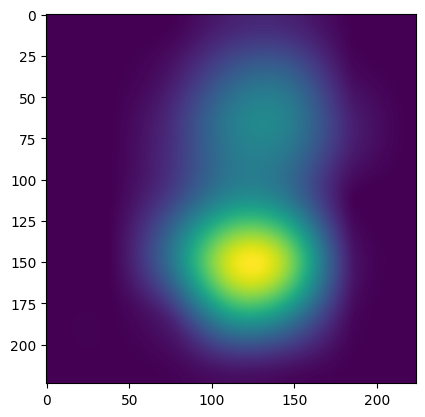

In [26]:
import matplotlib.pyplot as plt 

plt.imshow(cam_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.1957659].


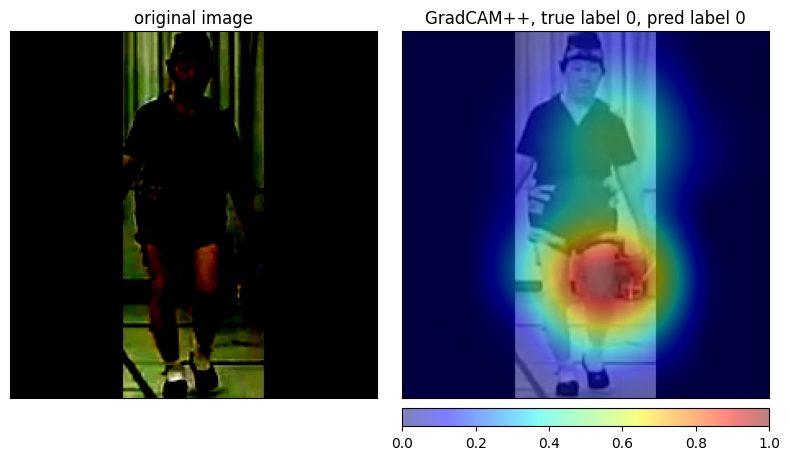

In [27]:
# use captum visual method
figure, axis = viz.visualize_image_attr_multiple(
        cam_map,
        inp_tensor,
        methods=['original_image', 'blended_heat_map'],
        signs=['all', 'positive'],
        show_colorbar=True,
        outlier_perc=1, 
        cmap='jet',
        titles = ['original image', 'GradCAM++, true label %s, pred label %s' % (int(inp_label), int(out_label))]
    )

In [28]:
input_tensor.shape

torch.Size([1, 3, 8, 224, 224])

In [29]:
from torchvision.io import write_video

write_video('1s.mp4', video_array=input_tensor.squeeze().permute(1,2,3,0).detach().cpu(), fps=10)

In [30]:
batch['video_name'][0]

'20190514_full_ap_22.mp4'